In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

import numpy as np
import scipy as sp
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colormaps

from analysis.analysis import *
from analysis.plot import *
from analysis.emg import *
from analysis.model import *

%matplotlib inline

In [2]:
subjects = load_subjects()

(-2.0, 2.0)

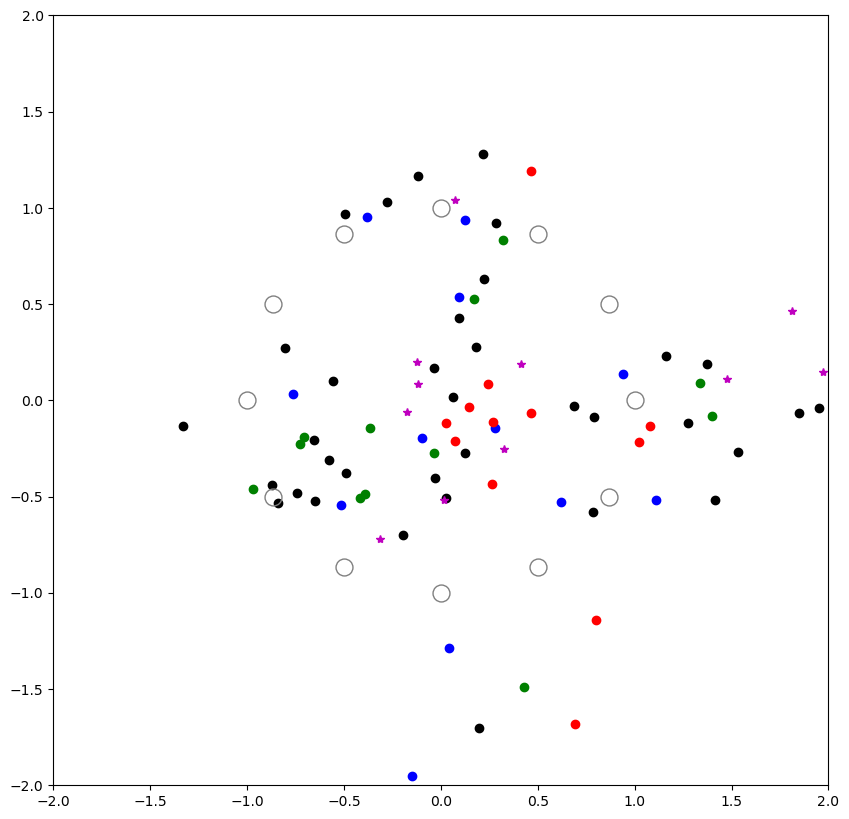

In [3]:
subject_idx = 7
decoder = subjects[subject_idx].decoder[-2:,:]
trial_models = load_log_trial_models(subject_idx)
calibration_model = load_log_calibration_models(subject_idx)
movement_model = load_log_movement_models(subject_idx)

plt.figure(figsize=(10,10))

c = ["g","k","k","k","b"]
for i, model in enumerate(trial_models):
    model = model_2d(log_model(model),decoder)
    for m in model.means:
        plt.plot(m[0],m[1],c[i]+"o")

for model in calibration_model:
    model = model_2d(log_model(model),decoder)
    for m in model.means:
        plt.plot(m[0],m[1],"ro")

for model in movement_model:
    model = model_2d(log_model(model),decoder)
    for m in model.means:
        plt.plot(m[0],m[1],"m*")

plot_weighted_targets(plt.gca(),[1/12 for _ in range(12)])
plt.ylim([-2,2])
plt.xlim([-2,2])

In [4]:
(decoder @ remove_nan_rows(np.load(f"subject_filtered_calibration_stacks.npy")[subject_idx].transpose(0,1,3,2).reshape(-1,64)).T).shape

(2, 31943)

In [5]:
trial_samples = decoder @ remove_nan_rows(load_trial_stack(subject_idx).transpose(0,1,3,2).reshape(-1,64))[:10000].T
calibration_samples = decoder @ remove_nan_rows(np.load(f"subject_filtered_calibration_stacks.npy")[subject_idx].transpose(0,1,3,2).reshape(-1,64)).T

print(trial_samples.shape, calibration_samples.shape)

(2, 10000) (2, 31943)


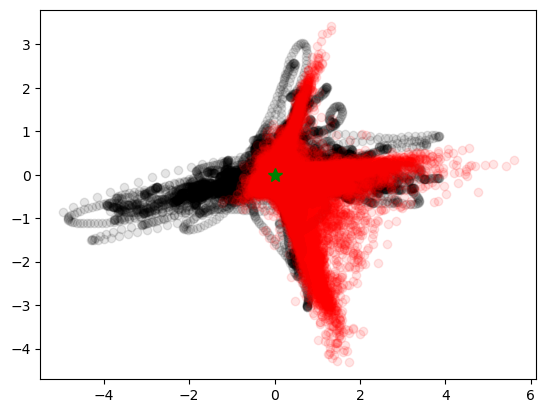

In [6]:
plt.plot(trial_samples[0],trial_samples[1],"ko",alpha=0.1)
plt.plot(calibration_samples[0],calibration_samples[1],"ro",alpha=0.1)
plt.plot([0],[0],"g*",markersize=10)

### can we predict performance from the calibration?

In [7]:
reward_df = pd.read_pickle("trajectory_dataframe.pkl")
mean_rewards = reward_df.groupby(level=["subject"]).mean()["reward"]**-1
mean_rewards.shape

(46,)

### calibration-trial difference?

0.3806250818421185


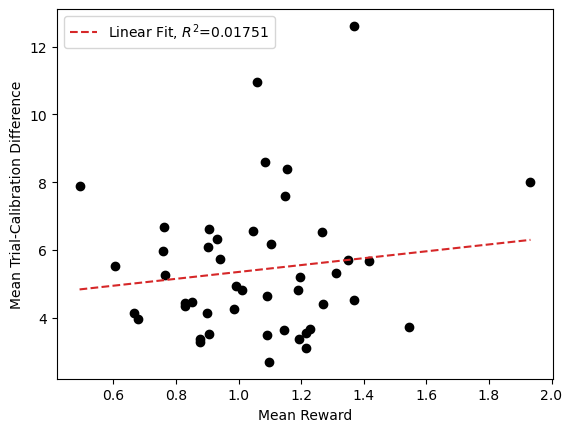

In [9]:
# subjects, model, component, singular vals
mean_diffs = []
for subject_idx in range(len(subjects)):
    trial_model = load_log_trial_models(subject_idx)[0]
    calibration_model = load_log_calibration_models(subject_idx)[0]
    diffs = []
    for k, (trial_cov, calibration_cov) in enumerate(zip(trial_model.covariances_,calibration_model.covariances_)):
        diffs.append(frobenius_difference(trial_cov,calibration_cov))
    mean_diffs.append(np.mean(diffs))

plt.plot(mean_rewards,mean_diffs,'ko')
res = linear_fit(mean_rewards, mean_diffs)
x = np.linspace(mean_rewards.min(),mean_rewards.max(),100)
plot_linear_fit(x, res, plt.gca())
plt.legend()
plt.ylabel("Mean Trial-Calibration Difference")
plt.xlabel("Mean Reward")
print(res.pvalue)

### find closest pairs, then compute Wasserstein between the two sets of mixtures

## test distance metric pairings

(3000, 2) (3000, 2)


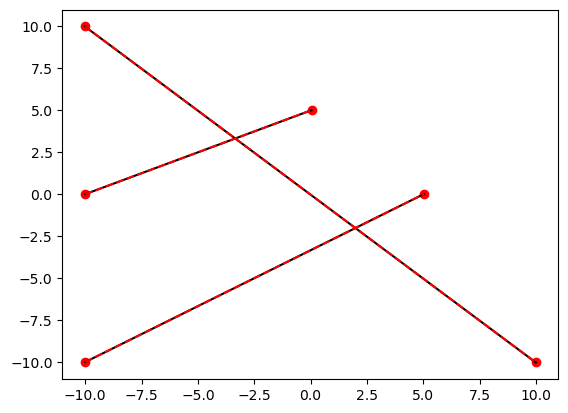

In [128]:
m0_1 = [-10,10]
m0_2 = [-10,00]
m0_3 = [-10,-10]

m1_1 = [0,5]
m1_2 = [5,00]
m1_3 = [10,-10]

S0 = np.array([[.1,-.01],[-.01,.1]])
S1 = np.array([[1,.3],[.3,1]])

g0_1 = np.random.multivariate_normal(m0_1,S0,size=(1000))
g0_2 = np.random.multivariate_normal(m0_2,S0,size=(1000))
g0_3 = np.random.multivariate_normal(m0_3,S0,size=(1000))
n0 = np.row_stack([g0_1,g0_2,g0_3])

g1_1 = np.random.multivariate_normal(m1_1,S1,size=(1000))
g1_2 = np.random.multivariate_normal(m1_2,S1,size=(1000))
g1_3 = np.random.multivariate_normal(m1_3,S1,size=(1000))
n1 = np.row_stack([g1_1,g1_2,g1_3])

print(n0.shape, n1.shape)

model0 = BayesianGaussianMixture(n_components=3,
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=1.0E-8,
                                max_iter=300,
                                n_init=2,
                                warm_start=True,
                                random_state=0,
                                )
model0.fit(n0)

model1 = BayesianGaussianMixture(n_components=3,
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=1.0E-8,
                                max_iter=300,
                                n_init=2,
                                warm_start=True,
                                random_state=0,
                                )
model1.fit(n1)

plot_model(model0.means_, model0.covariances_)
plot_model(model1.means_, model1.covariances_)

e_pairs = closest_pairs(model0.means_, model1.means_,)
w_pairs = closest_pairs_wasserstein(model0.means_, model1.means_,model0.covariances_, model1.covariances_)
plot_pairs(e_pairs, model0.means_, model1.means_)
plot_pairs(w_pairs, model0.means_, model1.means_,style="r--")

(-8.0, 8.0)

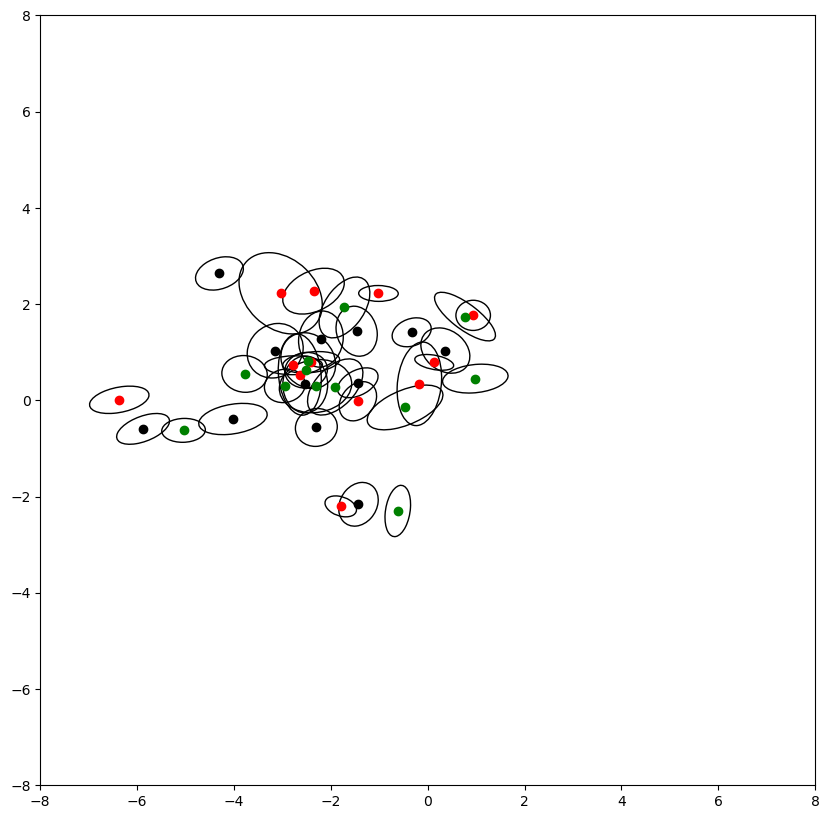

In [115]:
subject_idx = 31
decoder = subjects[subject_idx].decoder[-2:,:]

plt.figure(figsize=(10,10))

trial_model = load_log_trial_models(subject_idx)[0]
calibration_model = load_log_calibration_models(subject_idx)[0]
movement_model = load_log_movement_models(subject_idx)[0]

# e_pairs = closest_pairs(trial_model.means_, calibration_model.means_,)
# w_pairs = closest_pairs_wasserstein(trial_model.means_, calibration_model.means_,trial_model.covariances_, calibration_model.covariances_)

# trial_model_2d = model_2d(log_model(trial_model),decoder)
# calibration_model_2d = model_2d(log_model(calibration_model),decoder)

for mean, cov in zip(calibration_model.means_, calibration_model.covariances_):
    m = make_lognormal_mean(mean.reshape(-1,1),cov)
    c = make_lognormal_covariance(mean.reshape(-1,1),cov)
    m = transform_mean(decoder,mean)
    c = transform_covariance(decoder,cov)
    plt.plot(m[0],m[1],"ro")
    confidence_ellipse(m,c,plt.gca(),n_std=0.5)

for mean, cov in zip(trial_model.means_, trial_model.covariances_):
    m = make_lognormal_mean(mean.reshape(-1,1),cov)
    c = make_lognormal_covariance(mean.reshape(-1,1),cov)
    m = transform_mean(decoder,mean)
    c = transform_covariance(decoder,cov)
    plt.plot(m[0],m[1],"ko")
    confidence_ellipse(m,c,plt.gca(),n_std=0.5)

for mean, cov in zip(movement_model.means_, movement_model.covariances_):
    m = make_lognormal_mean(mean.reshape(-1,1),cov)
    c = make_lognormal_covariance(mean.reshape(-1,1),cov)
    m = transform_mean(decoder,mean)
    c = transform_covariance(decoder,cov)
    plt.plot(m[0],m[1],"go")
    confidence_ellipse(m,c,plt.gca(),n_std=0.5)

# plot_model(trial_model_2d.means, trial_model_2d.covariances)
# plot_model(calibration_model_2d.means, calibration_model_2d.covariances)

# plot_pairs(e_pairs, trial_model_2d.means, calibration_model_2d.means)
# plot_pairs(w_pairs, trial_model_2d.means, calibration_model_2d.means,style="r--")

plt.ylim([-8,8])
plt.xlim([-8,8])


## wasserstein distance pairs, but then use frobenius covariances to ignore offsets 

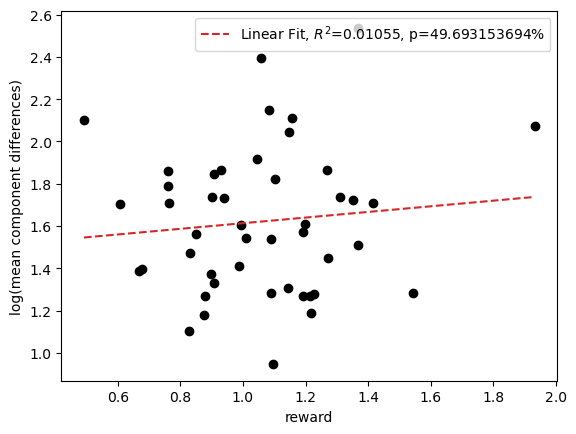

In [95]:
subject_diffs = []
for subject_idx in range(len(subjects)):
    trial_model = load_log_trial_models(subject_idx)[0]
    calibration_model = load_log_calibration_models(subject_idx)[0]
    pairs = closest_pairs_wasserstein(trial_model.means_,calibration_model.means_,trial_model.covariances_,calibration_model.covariances_)
    component_diffs = []
    for i, component_pair in enumerate(pairs):
        # model x --> model y
        # paired components
        component_diffs.append(frobenius_difference(trial_model.covariances_[component_pair[0]], calibration_model.covariances_[component_pair[1]]))
    subject_diffs.append(component_diffs)
    
mean_diffs = []
for i, model_diffs in enumerate(subject_diffs):
    # mean of the differences between subsequent models
    mean_diffs.append(np.mean(model_diffs))

plt.figure()
# plt.gca().set_yscale('log', base=2)
plt.plot(mean_rewards,np.log(mean_diffs),"ko")
r = linear_fit(mean_rewards,np.log(mean_diffs))
x = np.linspace(np.min(mean_rewards),np.max(mean_rewards),100)
plt.gca().plot(x, (r.intercept + r.slope*x),"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(r.rvalue**2, 5)}, p={np.round(r.pvalue*100,9)}%")
plt.ylabel("log(mean component differences)")
plt.xlabel("reward")
plt.legend()

### wasserstein distance (movement - trial 0)

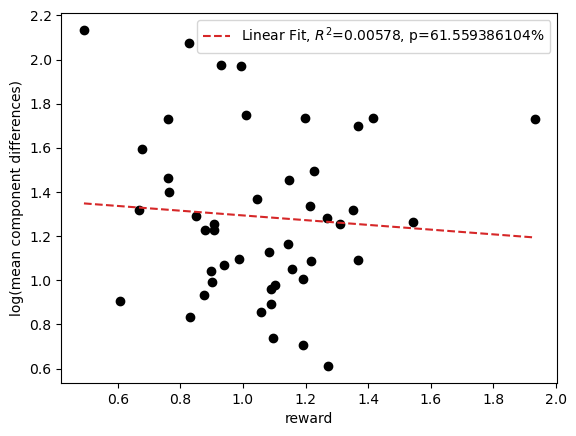

In [96]:
subject_diffs = []
for subject_idx in range(len(subjects)):
    trial_model = load_log_trial_models(subject_idx)[0]
    calibration_model = load_log_movement_models(subject_idx)[0]
    pairs = closest_pairs_wasserstein(trial_model.means_,calibration_model.means_,trial_model.covariances_,calibration_model.covariances_)
    component_diffs = []
    for i, component_pair in enumerate(pairs):
        # model x --> model y
        # paired components
        component_diffs.append(frobenius_difference(trial_model.covariances_[component_pair[0]], calibration_model.covariances_[component_pair[1]]))
    subject_diffs.append(component_diffs)
    
mean_diffs_movement = []
for i, model_diffs in enumerate(subject_diffs):
    # mean of the differences between subsequent models
    mean_diffs_movement.append(np.mean(model_diffs))

plt.figure()
# plt.gca().set_yscale('log', base=2)
plt.plot(mean_rewards,np.log(mean_diffs_movement),"ko")
r = linear_fit(mean_rewards,np.log(mean_diffs_movement))
x = np.linspace(np.min(mean_rewards),np.max(mean_rewards),100)
plt.gca().plot(x, (r.intercept + r.slope*x),"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(r.rvalue**2, 5)}, p={np.round(r.pvalue*100,9)}%")
plt.ylabel("log(mean component differences)")
plt.xlabel("reward")
plt.legend()

## compare calibration and movement

5.3733139448985705 3.8955152575058016


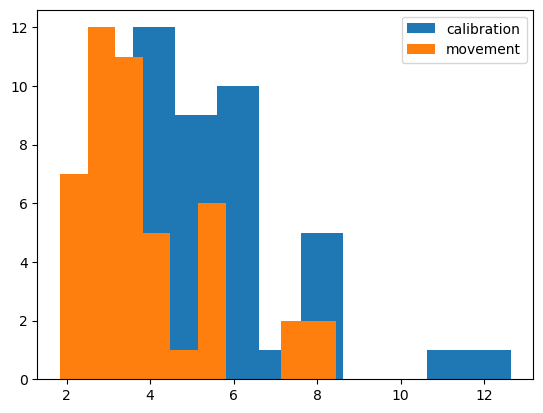

In [97]:
plt.hist(mean_diffs, label="calibration")
plt.hist(mean_diffs_movement, label="movement")
plt.legend()

print(np.mean(mean_diffs),np.mean(mean_diffs_movement))

## trial model wasserstein diffs

In [38]:
trial_diffs = []
for subject_idx in range(len(subjects)):
    log_models = load_log_trial_models(subject_idx)
    
    models = []
    for model in log_models:
        models.append(log_model(model))
    
    model_diffs = []
    for model0, model1 in zip(models[:-1],models[1:]):
        model_diffs.append(gmm_wasserstein(model0.weights,model1.weights,model0.means,model1.means,model0.covariances,model1.covariances))

    trial_diffs.append(model_diffs)

mean_diffs = []
for md in trial_diffs:
    mean_diffs.append(np.mean(md))


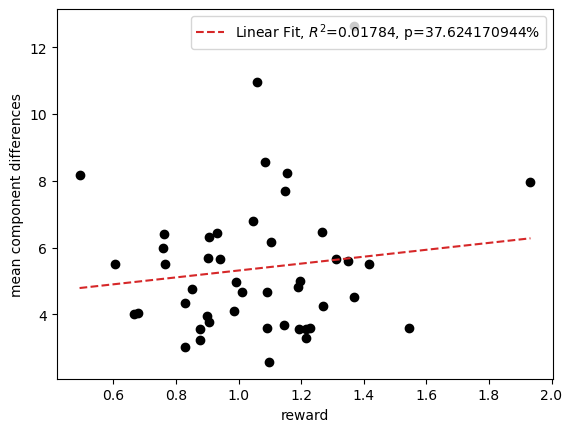

In [194]:
plt.figure()
# plt.gca().set_yscale('log', base=2)
plt.plot(mean_rewards,mean_diffs,"ko")
r = linear_fit(mean_rewards,mean_diffs)
x = np.linspace(np.min(mean_rewards),np.max(mean_rewards),100)
plt.gca().plot(x, (r.intercept + r.slope*x),"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(r.rvalue**2, 5)}, p={np.round(r.pvalue*100,9)}%")
plt.ylabel("mean component differences")
plt.xlabel("reward")
plt.legend()

## do model means move closer to targets?

73.71496122220849
(12, 2) (12, 2, 2)


(-3.0, 3.0)

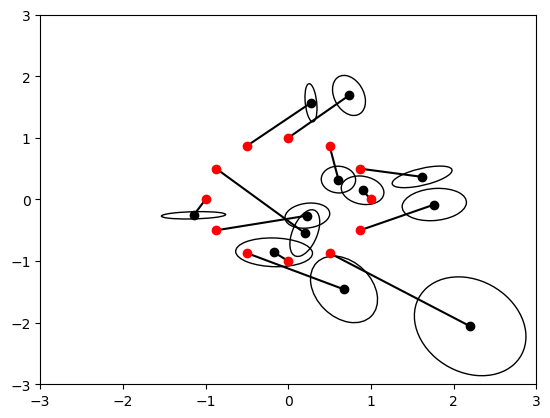

In [169]:
subject_idx = 5
decoder = subjects[subject_idx].decoder[-2:,:]
inv_decoder = np.linalg.pinv(decoder)

target_means = np.array([np.dot(inv_decoder,collection.compute_target_vec_from_number(i)) for i in range(1,13)])
target_covs = np.array([np.eye(64)*0.5 for _ in range(12)])
target_weights = np.array([1/12 for _ in range(12)])

model_means = load_log_trial_models(subject_idx)[0].means_
model_covs = load_log_trial_models(subject_idx)[0].covariances_
model_weights = load_log_trial_models(subject_idx)[0].weights_

pairs = closest_pairs_wasserstein(target_means,model_means,target_covs,model_covs)
d = gmm_wasserstein(target_weights,model_weights,target_means,model_means,target_covs,model_covs)
print(d)

plot_target_means = np.array([transform_mean(decoder,m) for m in target_means])
plot_target_covs = np.array([transform_covariance(decoder,c) for c in target_covs])
print(plot_target_means.shape, plot_target_covs.shape)

plot_model_covs = model_2d(log_model(load_log_trial_models(subject_idx)[0]),decoder).covariances
plot_model_means = model_2d(log_model(load_log_trial_models(subject_idx)[0]),decoder).means

plot_pairs(pairs,plot_target_means,plot_model_means)
plot_means(plot_target_means,"r")
plot_means(plot_model_means)
plot_covs(plot_model_means,plot_model_covs)
# plot_covs(plot_target_means,plot_target_covs)

plt.ylim([-3,3])
plt.xlim([-3,3])

81.66142669903633


(-3.0, 3.0)

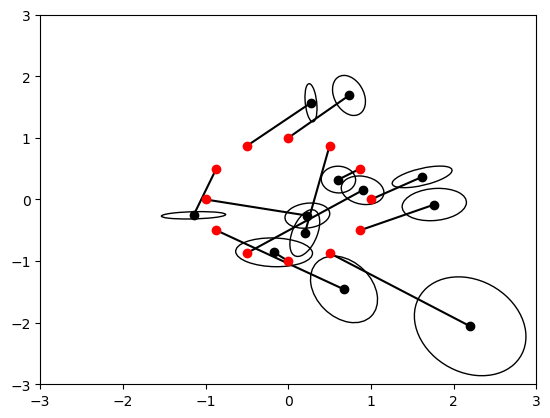

In [180]:
subject_idx = 5
decoder = subjects[subject_idx].decoder[-2:,:]
inv_decoder = np.linalg.pinv(decoder)

target_means = np.array([np.dot(inv_decoder,collection.compute_target_vec_from_number(i)) for i in range(1,13)])
target_covs = np.array([np.eye(64) for _ in range(12)])
target_weights = np.array([1/12 for _ in range(12)])

model_means = load_log_trial_models(subject_idx)[0].means_
model_covs = load_log_trial_models(subject_idx)[0].covariances_
model_weights = load_log_trial_models(subject_idx)[0].weights_

pairs, d = closest_pairs(target_means,model_means)
print(d)

plot_target_means = np.array([transform_mean(decoder,m) for m in target_means])
plot_target_covs = np.array([transform_covariance(decoder,c) for c in target_covs])

plot_model_covs = model_2d(log_model(load_log_trial_models(subject_idx)[0]),decoder).covariances
plot_model_means = model_2d(log_model(load_log_trial_models(subject_idx)[0]),decoder).means

plot_pairs(pairs,plot_target_means,plot_model_means)
plot_means(plot_target_means,"r")
plot_means(plot_model_means)
plot_covs(plot_model_means,plot_model_covs)
# plot_covs(plot_target_means,plot_target_covs)

plt.ylim([-3,3])
plt.xlim([-3,3])

In [190]:
subject_mean_ds = []
subject_mean_w2s = []
for subject_idx in range(46):
    decoder = subjects[subject_idx].decoder[-2:,:]
    inv_decoder = np.linalg.pinv(decoder)

    target_means = np.array([np.dot(inv_decoder,collection.compute_target_vec_from_number(i)) for i in range(1,13)])
    target_covs = np.array([np.eye(64) for _ in range(12)])
    target_weights = np.array([1/12 for _ in range(12)])

    ds = []
    w2s = []

    model = load_log_calibration_models(subject_idx)[0]
    model_means = model.means_
    model_covs = model.covariances_
    model_weights = model.weights_ 
    _, d = closest_pairs(target_means,model_means)
    w2 = gmm_wasserstein(target_weights,model_weights,target_means,model_means,target_covs,model_covs)
    ds.append(d)
    w2s.append(w2)

    model = load_log_movement_models(subject_idx)[0]
    model_means = model.means_
    model_covs = model.covariances_
    model_weights = model.weights_   
    _, d = closest_pairs(target_means,model_means)
    w2 = gmm_wasserstein(target_weights,model_weights,target_means,model_means,target_covs,model_covs)
    ds.append(d)
    w2s.append(w2)

    for model in load_log_trial_models(subject_idx):
        model_means = model.means_
        model_covs = model.covariances_
        model_weights = model.weights_
        _, d = closest_pairs(target_means,model_means)
        w2 = gmm_wasserstein(target_weights,model_weights,target_means,model_means,target_covs,model_covs)
        ds.append(d)
        w2s.append(w2)

    subject_mean_ds.append(ds)
    subject_mean_w2s.append(w2s)

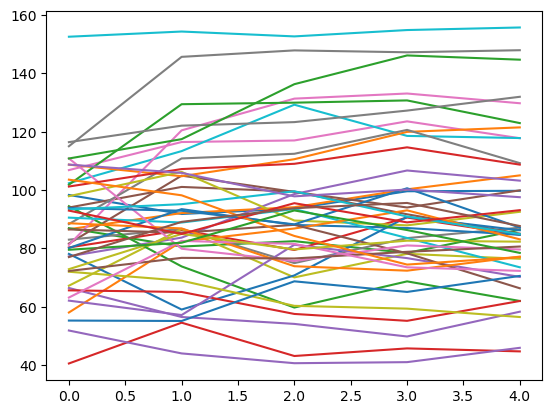

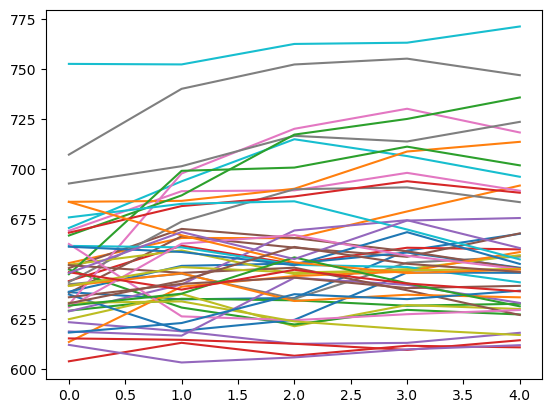

In [191]:
for ds in subject_mean_ds:
    plt.plot(ds[2:])

plt.figure()
for w2s in subject_mean_w2s:
    plt.plot(w2s[2:])